# Computer vision final project
## Meme-emotion Classification
### Irada Bunyatova & Victor Videau - M2 Artificial Intelligence & Advanced Visual Computing

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
from torchvision import models, transforms
import time
import os
import copy
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True # solves OSError: image file is truncated
from torch.utils import data
import numbers
from easynmt import EasyNMT
import transformers
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import Trainer, TrainingArguments
from sklearn.utils import class_weight, shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score

# Task 1: Sentiment Classification
### Given an Internet meme, classify it as a positive, negative or neutral meme

In [2]:
# code of this cell taken from https://discuss.pytorch.org/t/how-to-resize-and-pad-in-a-torchvision-transforms-compose/71850/2

def get_padding(image):    
    w, h = image.size
    max_wh = np.max([w, h])
    h_padding = (max_wh - w) / 2
    v_padding = (max_wh - h) / 2
    l_pad = h_padding if h_padding % 1 == 0 else h_padding+0.5
    t_pad = v_padding if v_padding % 1 == 0 else v_padding+0.5
    r_pad = h_padding if h_padding % 1 == 0 else h_padding-0.5
    b_pad = v_padding if v_padding % 1 == 0 else v_padding-0.5
    padding = (int(l_pad), int(t_pad), int(r_pad), int(b_pad))
    return padding

class NewPad(object):
    def __init__(self, fill=0, padding_mode='constant'):
        assert isinstance(fill, (numbers.Number, str, tuple))
        assert padding_mode in ['constant', 'edge', 'reflect', 'symmetric']
        self.fill = fill
        self.padding_mode = padding_mode
        
    def __call__(self, img):
        return transforms.functional.pad(img, get_padding(img), self.fill, self.padding_mode)
    
    def __repr__(self):
        return self.__class__.__name__ + '(padding={0}, fill={1}, padding_mode={2})'.\
            format(self.fill, self.padding_mode)

<b> Visualize data augmentation for images </b> <br>
Rerun this cell to see different image augmentation examples

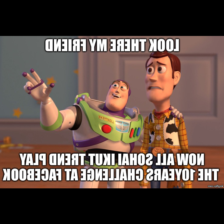

In [3]:
image = Image.open('memotion_dataset_7k/images/image_1.jpg').convert('RGB')
transfo = transforms.Compose([
    transforms.RandomApply(nn.ModuleList([transforms.RandomCrop(500, pad_if_needed=True)]), p=0.2),
    transforms.RandomApply(nn.ModuleList([transforms.ColorJitter(0.2, 0.2, 0.2, 0.03)]), p=0.2),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomPerspective(p=0.2),
    NewPad(),
    transforms.Resize(224)])

transfo(image)

<b> load a pre-trained image classifier </b>

In [4]:
def initialize_model(model_name, num_classes, use_pretrained=True):
    """function adapted from https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
    """
    input_size = 224
    
    if model_name == "squeezenet": # Squeezenet : 736 963 parameters
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
    
    elif model_name == "densenet": # Densenet : 6 956 931 parameters
        model_ft = models.densenet121(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
    
    elif model_name == "resnet": # Resnet18 : 11 178 051 parameters
        model_ft = models.resnet18(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)

    elif model_name == "inception": # Inception v3 : 24 351 718 parameters
        model_ft = models.inception_v3(pretrained=use_pretrained)
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [5]:
train_prop = 0.8
batch_size = 64
num_epochs = 5
# Models to choose from [squeezenet, densenet, resnet, inception]
model_name = 'resnet'

<b> Image Processing and augmentation only for the training images are augmented </b>

In [6]:
input_size = 224 if model_name != 'inception' else 299

data_transform_val = transforms.Compose([
    NewPad(),
    transforms.Resize(input_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

data_transform = transforms.Compose([
    transforms.RandomApply(nn.ModuleList([transforms.RandomCrop(500, pad_if_needed=True)]), p=0.3),
    transforms.RandomApply(nn.ModuleList([transforms.ColorJitter(0.2, 0.2, 0.2, 0.03)]), p=0.3),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomPerspective(p=0.3),
    transforms.RandomAdjustSharpness(50, p=0.2),
    NewPad(),
    transforms.Resize(input_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

## Task 1 (a) : Sentiment Classification with Images only

In [7]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10, is_inception=False):
    """function adapted from https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
    """
    since = time.time()
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    preds = torch.max(outputs, 1)[1]
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model, val_acc_history


class MemeDataSet(data.Dataset):
    
    def __init__(self, main_dir, transform, ds):
        self.img_dir = main_dir+'/images'
        self.transform = transform
        self.total_imgs = sorted(ds.image_name)
        self.labels = ds

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.img_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert('RGB')
        tensor_image = self.transform(image)
        image_name = img_loc.replace('\\', '/').split('/')[-1]
        image_row = self.labels[self.labels.image_name == image_name]
        label = image_row.overall_sentiment.item()
        return tensor_image, label


def process_labels_csv(file_loc, dropna=True):
    labels = pd.read_csv(file_loc)
    labels.overall_sentiment = labels.overall_sentiment.apply(lambda x: 0 if 'negative' in x else 1 if x == 'neutral' else 2)
    labels = labels.drop(['Unnamed: 0', 'text_ocr', 'motivational'], axis=1)
    if dropna:
        labels = labels.dropna()
    return labels

In [8]:
model_task1_a, input_size = initialize_model(model_name, num_classes=3, use_pretrained=True)
ds = process_labels_csv('memotion_dataset_7k/labels.csv')
meme_ids = np.unique(ds.index, return_index=True)[1]
train_id, val_id = train_test_split(meme_ids, train_size=train_prop, random_state=69, \
                                    stratify=ds.iloc[meme_ids].overall_sentiment)

train_id_img = train_id.copy()  # check to ensure same train-val sets for
val_id_img = val_id.copy()      # this model and the upcoming text model
ds_train = ds[ds.index.isin(train_id)]
ds_val = ds[ds.index.isin(val_id)]
meme_dataset_train = MemeDataSet('memotion_dataset_7k', data_transform, ds_train)
meme_dataset_val = MemeDataSet('memotion_dataset_7k', data_transform_val, ds_val)
train_loader = data.DataLoader(meme_dataset_train, batch_size=batch_size, shuffle=True)
val_loader = data.DataLoader(meme_dataset_val, batch_size=batch_size)
dataloaders_dict = {'train': train_loader, 'val': val_loader}
device = torch.device('cuda:0')
model_task1_a, input_size = initialize_model(model_name, num_classes=3, use_pretrained=True)
model_task1_a = model_task1_a.to(device)
sentiment_labels = ds.overall_sentiment
class_w = class_weight.compute_class_weight('balanced', classes=np.unique(sentiment_labels), y=sentiment_labels)
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(class_w).to(device))

<b> If one wants to freeze the first k layers of the pre-trained network </b> <br>
Unfortunately it did not help to generalize better on the validation set

In [9]:
# cell from https://discuss.pytorch.org/t/how-the-pytorch-freeze-network-in-some-layers-only-the-rest-of-the-training/7088/2
k = 0 # 0 -> no freezing at all
for cpt, child in enumerate(model_task1_a.children()):
    if cpt < k:
        for param in child.parameters():
            param.requires_grad = False

In [10]:
params_to_update = model_task1_a.parameters()
optimizer_ft = optim.Adam(params_to_update, lr=0.0001, weight_decay=1e-3)

In [11]:
model_task1_a, hist = train_model(model_task1_a, dataloaders_dict, criterion, optimizer_ft, num_epochs)

Epoch 0/4
----------


C:\Users\vicvi\anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 1.1835 Acc: 0.3192
val Loss: 1.1269 Acc: 0.3264

Epoch 1/4
----------
train Loss: 1.0969 Acc: 0.3907
val Loss: 1.1637 Acc: 0.3686

Epoch 2/4
----------
train Loss: 1.0633 Acc: 0.4281
val Loss: 1.3083 Acc: 0.4059

Epoch 3/4
----------
train Loss: 1.0062 Acc: 0.4711
val Loss: 1.3059 Acc: 0.4896

Epoch 4/4
----------
train Loss: 0.9751 Acc: 0.4831
val Loss: 1.3109 Acc: 0.4180

Training complete in 10m 43s
Best val Acc: 0.489621


## Task 1 (b) : Sentiment Classification with Texts only

In [12]:
class MemeText(data.Dataset):
    
    def __init__(self, ds):
        texts = list(ds.text_corrected)
        tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased', do_lower_case=True)
        #tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-base', do_lower_case=True)
        self.encodings = tokenizer(texts, return_tensors='pt', padding='max_length', \
                                   truncation=True, max_length=30) # between 30 and 40
        self.labels = np.array(ds.overall_sentiment, dtype=int)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        onehot_lab = torch.Tensor([0, 0, 0])
        onehot_lab[self.labels[idx]] = 1
        item['labels'] = onehot_lab
        return item

In [13]:
ds = pd.read_csv('memotion_dataset_7k/augmented.csv').drop('Unnamed: 0', axis=1)
meme_ids = np.unique(ds.meme_id, return_index=True)[1]
train_id, val_id = train_test_split(meme_ids, train_size=train_prop, random_state=69, \
                                    stratify=ds.iloc[meme_ids].overall_sentiment)

assert (train_id_img == train_id).mean() == 1, 'Train sets not the same for image and text models'
assert (val_id_img == val_id).mean() == 1, 'Validation sets not the same for image and text models'

ds_train = ds[ds.meme_id.isin(train_id)]
ds_train0 = ds_train[ds_train.overall_sentiment == 0]
ds_train1 = ds_train[ds_train.overall_sentiment == 1]
ds_train2 = ds_train[ds_train.overall_sentiment == 2]
class_sizes = min(np.unique(ds_train.overall_sentiment, return_counts=True)[1])
while len(ds_train0) > class_sizes: ds_train0 = ds_train0.drop(np.random.choice(ds_train0.index))
while len(ds_train1) > class_sizes: ds_train1 = ds_train1.drop(np.random.choice(ds_train1.index))
while len(ds_train2) > class_sizes: ds_train2 = ds_train2.drop(np.random.choice(ds_train2.index))
ds_train = pd.concat((ds_train0, ds_train1, ds_train2))
ds_val = ds[ds.meme_id.isin(val_id)] # take all text generated
ds_val = ds.iloc[val_id] # take only the original sentences
train_set = MemeText(ds_train)
val_set = MemeText(ds_val)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size)

In [14]:
# code of this cell from our NLP course practicals at Ecole Polytechnique

def compute_metrics(pred):
    labels = pred.label_ids
    labels = np.where(labels == 1)[1].astype(int) # from onehot to positional
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    w_preci = precision_score(labels, preds, average='weighted')
    return {'accuracy': accuracy, 'weighted precision': w_preci}

training_args = TrainingArguments(
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=1e-4,              # initial learning rate for Adam optimizer
    warmup_steps=100,                # number of warmup steps for learning rate scheduler
    weight_decay=0.02,               # strength of weight decay
    output_dir='./results',          # output directory
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,               # number of steps to output logging (set lower because of small dataset size)
    report_to='all',
    evaluation_strategy='steps',     # evaluate during fine-tuning so that we can see progress
)

def fine_tuning(dataset, test_dataset, compute_metrics, n_lab=3):
    model_ft = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=n_lab).to('cuda')
    #model_ft = AutoModelForSequenceClassification.from_pretrained('vinai/bertweet-base', num_labels=3).to('cuda')
    #config = transformers.DistilBertConfig(dropout=0.5, attention_dropout=0.5, seq_classif_dropout=0.5)
    #model_ft = DistilBertForSequenceClassification(config).from_pretrained('distilbert-base-uncased', num_labels=3).to('cuda')
    trainer = Trainer(model=model_ft,
                      args=training_args,
                      train_dataset=dataset,
                      eval_dataset=test_dataset,
                      compute_metrics=compute_metrics)
    return trainer

In [15]:
model_task1_b = fine_tuning(train_set, val_set, compute_metrics)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classi

In [16]:
model_task1_b.train()

***** Running training *****
  Num examples = 19944
  Num Epochs = 2
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 624


Step,Training Loss,Validation Loss,Accuracy,Weighted precision
100,0.640400,0.618253,0.444206,0.467302
200,0.586000,0.657769,0.434907,0.490839
300,0.500100,0.597421,0.502146,0.474512
400,0.348500,0.686783,0.479971,0.483491
500,0.296100,0.720933,0.509299,0.471865
600,0.272700,0.732312,0.501431,0.473098


***** Running Evaluation *****
  Num examples = 1398
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1398
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1398
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1398
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1398
  Batch size = 64
Saving model checkpoint to ./results\checkpoint-500
Configuration saved in ./results\checkpoint-500\config.json
Model weights saved in ./results\checkpoint-500\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1398
  Batch size = 64


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=624, training_loss=0.4336520601541568, metrics={'train_runtime': 48.718, 'train_samples_per_second': 818.753, 'train_steps_per_second': 12.808, 'total_flos': 309606669593280.0, 'train_loss': 0.4336520601541568, 'epoch': 2.0})

In [17]:
model_task1_b.evaluate()

***** Running Evaluation *****
  Num examples = 1398
  Batch size = 64


{'eval_loss': 0.7457491755485535,
 'eval_accuracy': 0.47639484978540775,
 'eval_weighted precision': 0.46928911825471076,
 'eval_runtime': 0.4679,
 'eval_samples_per_second': 2987.93,
 'eval_steps_per_second': 47.02,
 'epoch': 2.0}

## Task 1 (c) : Sentiment Classification - inputs are the Images + Texts

In [18]:
class ImageTextVoting:
    
    def __init__(self, image_clf, text_clf):
        self.image_clf = image_clf.to('cuda')
        self.text_clf = text_clf
        self.softmax = nn.Softmax(dim=1)
    
    def predict(self, ds_test):
        self.image_clf.eval()
        self.text_clf.is_in_train = False
        image_test_set = MemeDataSet('memotion_dataset_7k', data_transform_val, ds_test)
        image_test_loader = data.DataLoader(image_test_set, batch_size=6)
        text_test_set = MemeText(ds_test)
        text_outputs = self.text_clf.predict(text_test_set)
        text_probas = self.softmax(torch.tensor(text_outputs.predictions))
        img_outputs = torch.empty((0, 3))
        with torch.no_grad():
            for img_inputs, img_labels in image_test_loader:
                img_inputs = img_inputs.to(device)
                img_labels = img_labels.to(device)
                batch_output = self.image_clf(img_inputs)
                img_outputs = torch.cat((img_outputs, batch_output.to('cpu')))
        
        img_probas = self.softmax(img_outputs)
        probas_vote = 0.5*img_probas + 0.5*text_probas
        final_preds = np.argmax(probas_vote, axis=1)
        
        return final_preds

In [30]:
voting_task1_c = ImageTextVoting(model_task1_a, model_task1_b)
y_pred = voting_task1_c.predict(ds_val)

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at C:\Users\vicvi/.cache\huggingface\transformers\0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer.json from cache at C:\Users\vicvi/.cache\huggingface\transformers\75abb59d7a06f4f640158a9bfcde005264e59e8d566781ab1415b139d2e4c603.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer_config.json from cache at C:\Users\vicvi/.cache\huggingface\transformers\8c8624b8ac8aa99c60c912161f8332de003484428c47906d7ff7eb7f73eecdbb.

In [31]:
y_true = ds_val.overall_sentiment
acc = accuracy_score(y_true, y_pred)
w_preci = precision_score(y_true, y_pred, average='weighted')
print('Accuracy :', round(acc, 4))
print('Weighted precision :', round(w_preci, 4))

Accuracy : 0.5007
Weighted precision : 0.4872


# Task 2: Humour Classification
### Given an Internet meme, identify the type of humor expressed (sarcastic, humorous, and offensive)

In [32]:
def process_labels_csv_humour(file_loc, dropna=True):
    labels = pd.read_csv(file_loc)
    labels.sarcasm = labels.sarcasm.apply(lambda x: 0 if x == 'not_sarcastic' else 1)
    labels.humour = labels.humour.apply(lambda x: 0 if x == 'not_funny' else 1)
    labels.offensive = labels.offensive.apply(lambda x: 0 if x == 'not_offensive' else 1)
    labels = labels.drop(['Unnamed: 0', 'text_ocr', 'motivational'], axis=1)
    if dropna:
        labels = labels.dropna()
    return labels

## Task 2 (a) : Humour Classification with Images only

In [33]:
def train_model_humour(model, dataloaders, criterion, optimizer, num_epochs=10, is_inception=False):
    since = time.time()
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        tens = torch.zeros(len(outputs), 3)
                        for i in range(0,len(outputs)):
                            for j in range(0,3):
                                if (outputs[i,j].item() >= 0 and labels[i,j] == 1):
                                    tens[i,j] = 1
                                elif(outputs[i,j].item() < 0 and labels[i,j] == 0):
                                    tens[i,j] = 1
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += tens.sum()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            
            epoch_acc = running_corrects.double() / (len(dataloaders[phase].dataset) * 3) # because we have three classes
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model, val_acc_history


class MemeDataSetHumour(data.Dataset):
    
    def __init__(self, main_dir, transform, ds):
        self.img_dir = main_dir+'/images'
        self.transform = transform
        self.total_imgs = sorted(ds.image_name)
        self.labels = ds

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.img_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert('RGB')
        tensor_image = self.transform(image)
        image_name = img_loc.replace('\\', '/').split('/')[-1]
        image_row = self.labels[self.labels.image_name == image_name]
        label1 = image_row.sarcasm.item()
        label2 = image_row.humour.item()
        label3 = image_row.offensive.item()
        label = torch.Tensor([label1, label2, label3])
        return tensor_image, label

In [34]:
ds = process_labels_csv_humour('memotion_dataset_7k/labels.csv')
ds.overall_sentiment = ds.overall_sentiment.apply(lambda x: 0 if 'negative' in x else 1 if x == 'neutral' else 2)
meme_ids = np.unique(ds.index, return_index=True)[1]
train_id, val_id = train_test_split(meme_ids, train_size=train_prop, random_state=69)
train_id_img = train_id.copy()  # check to ensure same train-val sets for
val_id_img = val_id.copy()      # this model and the upcoming text model

ds_train = ds[ds.index.isin(train_id)]
ds_val = ds[ds.index.isin(val_id)]
meme_dataset_train = MemeDataSetHumour('memotion_dataset_7k', data_transform, ds_train)
meme_dataset_val = MemeDataSetHumour('memotion_dataset_7k', data_transform_val, ds_val)
train_loader = data.DataLoader(meme_dataset_train, batch_size=batch_size, shuffle=True)
val_loader = data.DataLoader(meme_dataset_val, batch_size=batch_size)
dataloaders_dict = {'train': train_loader, 'val': val_loader}
device = torch.device('cuda:0')
model_task2_a, input_size = initialize_model(model_name, num_classes=3, use_pretrained=True)
model_task2_a = model_task2_a.to(device)

meme_dataset_humour = ds
bin_humour = np.bincount(meme_dataset_humour.humour)
w_humour = bin_humour[0] / bin_humour[1]
bin_sarcasm = np.bincount(meme_dataset_humour.sarcasm)
w_sarcasm = bin_sarcasm[0] / bin_sarcasm[1]
bin_off = np.bincount(meme_dataset_humour.offensive)
w_off = bin_off[0] / bin_off[1]
bin_class_w = torch.Tensor([w_sarcasm, w_humour, w_off]).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=bin_class_w)
params_to_update = model_task2_a.parameters()
optimizer_ft = optim.Adam(params_to_update, lr=0.0001)

In [10]:
model_task2_a, hist = train_model_humour(model_task2_a, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/4
----------


C:\Users\vicvi\anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.4043 Acc: 0.5143
val Loss: 0.4006 Acc: 0.4831

Epoch 1/4
----------
train Loss: 0.3874 Acc: 0.5528
val Loss: 0.4016 Acc: 0.5043

Epoch 2/4
----------
train Loss: 0.3796 Acc: 0.5722
val Loss: 0.4037 Acc: 0.5286

Epoch 3/4
----------
train Loss: 0.3704 Acc: 0.6040
val Loss: 0.4154 Acc: 0.4683

Epoch 4/4
----------
train Loss: 0.3585 Acc: 0.6292
val Loss: 0.4259 Acc: 0.4814

Training complete in 14m 14s
Best val Acc: 0.528612


## Task 2 (b) : Humour Classification with Texts only

In [35]:
class MemeTextHumour(data.Dataset):
    
    def __init__(self, ds):
        texts = list(ds.text_corrected)
        tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased', do_lower_case=True)
        #tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-base', do_lower_case=True)
        self.encodings = tokenizer(texts, return_tensors='pt', padding='max_length', \
                                   truncation=True, max_length=30) # between 30 and 40
        self.humour = np.array(ds.humour, dtype=int)
        self.sarcasm = np.array(ds.sarcasm, dtype=int)
        self.offensive = np.array(ds.offensive, dtype=int)

    def __len__(self):
        return len(self.humour)

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        onehot_lab = torch.Tensor([0, 0, 0])
        onehot_lab[0] = self.sarcasm[idx]
        onehot_lab[1] = self.humour[idx]
        onehot_lab[2] = self.offensive[idx]
        item['labels'] = onehot_lab
        return item


def compute_metrics_humour(pred):
    labels = pred.label_ids
    outputs = pred.predictions
    tens = torch.zeros(labels.shape[0], labels.shape[1])
    for i in range(len(outputs)):
        for j in range(labels.shape[1]):
            if (outputs[i,j].item() >= 0 and labels[i,j] == 1):
                tens[i,j] = 1
            elif(outputs[i,j].item() < 0 and labels[i,j] == 0):
                tens[i,j] = 1
    accuracy = tens.mean()
    return {
      'accuracy': accuracy,
  }

In [36]:
ds = pd.read_csv('memotion_dataset_7k/augmented.csv').drop('Unnamed: 0', axis=1)
ds.sarcasm = ds.sarcasm.apply(lambda x: 0 if x == 'not_sarcastic' else 1)
ds.humour = ds.humour.apply(lambda x: 0 if x == 'not_funny' else 1)
ds.offensive = ds.offensive.apply(lambda x: 0 if x == 'not_offensive' else 1)

meme_ids = np.unique(ds.meme_id, return_index=True)[1]
train_id, val_id = train_test_split(meme_ids, train_size=train_prop, random_state=69)

assert (train_id_img == train_id).mean() == 1, 'Train sets not the same for image and text models'
assert (val_id_img == val_id).mean() == 1, 'Validation sets not the same for image and text models'

ds_train = ds[ds.meme_id.isin(train_id)]
ds_sarcasm = ds_train[ds_train.sarcasm == 0]
ds_sarcasm_1 = ds_train[ds_train.sarcasm == 1]
ds_balanced = pd.concat((ds_sarcasm, shuffle(ds_sarcasm_1, random_state=69).iloc[:4582]))
ds_train = ds_balanced

ds_val = ds[ds.meme_id.isin(val_id)] # take all text generated
ds_val = ds.iloc[val_id] # take only the original sentences
train_set = MemeTextHumour(ds_train)
val_set = MemeTextHumour(ds_val)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size)

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at C:\Users\vicvi/.cache\huggingface\transformers\0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer.json from cache at C:\Users\vicvi/.cache\huggingface\transformers\75abb59d7a06f4f640158a9bfcde005264e59e8d566781ab1415b139d2e4c603.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer_config.json from cache at C:\Users\vicvi/.cache\huggingface\transformers\8c8624b8ac8aa99c60c912161f8332de003484428c47906d7ff7eb7f73eecdbb.

In [37]:
training_args = TrainingArguments(
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=1e-4,              # initial learning rate for Adam optimizer
    warmup_steps=100,                # number of warmup steps for learning rate scheduler
    weight_decay=0.02,               # strength of weight decay
    output_dir='./results',          # output directory
    logging_dir='./logs',            # directory for storing logs
    logging_steps=80,               # number of steps to output logging (set lower because of small dataset size)
    report_to='all',
    evaluation_strategy='steps',     # evaluate during fine-tuning so that we can see progress
)

model_task2_b = fine_tuning(train_set, val_set, compute_metrics_humour)

using `logging_steps` to initialize `eval_steps` to 80
PyTorch: setting up devices
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at C:\Users\vicvi/.cache\huggingface\transformers\23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version":

In [23]:
model_task2_b.train()

***** Running training *****
  Num examples = 9402
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 441


Step,Training Loss,Validation Loss,Accuracy
80,0.681400,0.652714,0.600620
160,0.640500,0.709854,0.615641
240,0.511700,0.716523,0.632093
320,0.406100,0.871705,0.608727
400,0.263500,0.971327,0.597997


***** Running Evaluation *****
  Num examples = 1398
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1398
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1398
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1398
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1398
  Batch size = 64


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=441, training_loss=0.47676870125491605, metrics={'train_runtime': 53.7273, 'train_samples_per_second': 524.985, 'train_steps_per_second': 8.208, 'total_flos': 218932153092360.0, 'train_loss': 0.47676870125491605, 'epoch': 3.0})

In [24]:
model_task2_b.evaluate()

***** Running Evaluation *****
  Num examples = 1398
  Batch size = 64


{'eval_loss': 0.9673082232475281,
 'eval_accuracy': 0.5968049764633179,
 'eval_runtime': 0.7445,
 'eval_samples_per_second': 1877.793,
 'eval_steps_per_second': 29.55,
 'epoch': 3.0}

## Task 2 (c) : Humour Classification with Images and Texts

In [38]:
class ImageTextVotingTask2:
    
    def __init__(self, image_clf, text_clf):
        self.image_clf = image_clf.to('cuda')
        self.text_clf = text_clf
        self.softmax = nn.Softmax(dim=1)
    
    def predict(self, ds_test):
        self.image_clf.eval()
        self.text_clf.is_in_train = False
        image_test_set = MemeDataSetHumour('memotion_dataset_7k', data_transform_val, ds_test)
        image_test_loader = data.DataLoader(image_test_set, batch_size=6)
        text_test_set = MemeTextHumour(ds_test)
        text_outputs = self.text_clf.predict(text_test_set)
        sigm = nn.Sigmoid()
        text_probas = sigm(torch.tensor(text_outputs.predictions))
        img_outputs = torch.empty((0, 3))
        with torch.no_grad():
            for img_inputs, img_labels in image_test_loader:
                img_inputs = img_inputs.to(device)
                img_labels = img_labels.to(device)
                batch_output = self.image_clf(img_inputs).to('cpu')
                img_outputs = torch.cat((img_outputs, sigm(batch_output)))
                
        img_probas = img_outputs
        probas_vote = 0.5*img_probas + 0.5*text_probas
        final_preds = (probas_vote >= 0.5).numpy().astype(int)
        
        return final_preds

In [90]:
voting_task2 = ImageTextVotingTask2(model_task2_a, model_task2_b)
y_pred = voting_task2.predict(ds_val)

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at C:\Users\vicvi/.cache\huggingface\transformers\0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer.json from cache at C:\Users\vicvi/.cache\huggingface\transformers\75abb59d7a06f4f640158a9bfcde005264e59e8d566781ab1415b139d2e4c603.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer_config.json from cache at C:\Users\vicvi/.cache\huggingface\transformers\8c8624b8ac8aa99c60c912161f8332de003484428c47906d7ff7eb7f73eecdbb.

In [27]:
y_true = ds_val[['sarcasm', 'humour', 'offensive']]
acc = (y_true == y_pred).mean()
print('\t\t    Accuracy\n', round(acc, 4), sep='')
print('\nmean accuracy :', round(acc.mean(), 4))

		    Accuracy
sarcasm      0.6016
humour       0.6924
offensive    0.5236
dtype: float64

mean accuracy : 0.6059


# Task 3: Multi-task classification
### Create one model that solves both Tasks 1 and 2 at the same time<br>
## Task 3 (a) : Multi-task classification with Images only

In [39]:
def train_model_task3(model, dataloaders, criterion, optimizer, num_epochs=10, is_inception=False):
    since = time.time()
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        acc = 0
                        for i in range(0,len(outputs)):
                            for j in range(0,3):
                                if (outputs[i,j].item() >= 0 and labels[i,j] == 1):
                                    acc += 0.25
                                elif(outputs[i,j].item() < 0 and labels[i,j] == 0):
                                    acc += 0.25
                            if labels[i, 3:] [np.argmax(outputs[i, 3:].detach().cpu())] == 1:
                                acc += 0.25

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += acc

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            
            epoch_acc = running_corrects / (len(dataloaders[phase].dataset))
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model, val_acc_history


class MemeDataSetTask3(data.Dataset):
    
    def __init__(self, main_dir, transform, ds):
        self.img_dir = main_dir+'/images'
        self.transform = transform
        self.total_imgs = sorted(ds.image_name)
        self.labels = ds
        
    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.img_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert('RGB')
        tensor_image = self.transform(image)
        image_name = img_loc.replace('\\', '/').split('/')[-1]
        image_row = self.labels[self.labels.image_name == image_name]
        label1 = image_row.sarcasm.item()
        label2 = image_row.humour.item()
        label3 = image_row.offensive.item()
        label4 = image_row.overall_sentiment.item()
        label = torch.zeros(6)
        label[0] = label1
        label[1] = label2
        label[2] = label3
        label[3+label4] = 1
        
        return tensor_image, label

In [40]:
ds = process_labels_csv_humour('memotion_dataset_7k/labels.csv')
ds.overall_sentiment = ds.overall_sentiment.apply(lambda x: 0 if 'negative' in x else 1 if x == 'neutral' else 2)
meme_ids = np.unique(ds.index, return_index=True)[1]
train_id, val_id = train_test_split(meme_ids, train_size=train_prop, random_state=69)
train_id_img = train_id.copy()  # check to ensure same train-val sets for
val_id_img = val_id.copy()      # this model and the upcoming text model

ds_train = ds[ds.index.isin(train_id)]
ds_val = ds[ds.index.isin(val_id)]
meme_dataset_train = MemeDataSetTask3('memotion_dataset_7k', data_transform, ds_train)
meme_dataset_val = MemeDataSetTask3('memotion_dataset_7k', data_transform_val, ds_val)
train_loader = data.DataLoader(meme_dataset_train, batch_size=batch_size, shuffle=True)
val_loader = data.DataLoader(meme_dataset_val, batch_size=batch_size)
dataloaders_dict = {'train': train_loader, 'val': val_loader}
device = torch.device('cuda:0')
model_task3_a, input_size = initialize_model(model_name, num_classes=6, use_pretrained=True)
model_task3_a = model_task3_a.to(device)

bin_humour = np.bincount(ds.humour)
w_humour = bin_humour[0] / bin_humour[1]
bin_sarcasm = np.bincount(ds.sarcasm)
w_sarcasm = bin_sarcasm[0] / bin_sarcasm[1]
bin_off = np.bincount(ds.offensive)
w_off = bin_off[0] / bin_off[1]
w_class4 = (len(ds_train) - len(ds_train[ds_train['overall_sentiment']==0])) / len(ds_train['overall_sentiment']==0)
w_class5 = (len(ds_train) - len(ds_train[ds_train['overall_sentiment']==1])) / len(ds_train['overall_sentiment']==1)
w_class6 = (len(ds_train) - len(ds_train[ds_train['overall_sentiment']==2])) / len(ds_train['overall_sentiment']==2)
bin_class_w = torch.Tensor([w_sarcasm, w_humour, w_off, w_class4, w_class5, w_class6]).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=bin_class_w)
params_to_update = model_task3_a.parameters()
optimizer_ft = optim.Adam(params_to_update, lr=0.0001)

In [41]:
model_task3_a, hist = train_model_task3(model_task3_a, dataloaders_dict, criterion, optimizer_ft, num_epochs)

Epoch 0/4
----------


C:\Users\vicvi\anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.4382 Acc: 0.4942
val Loss: 0.4099 Acc: 0.5536

Epoch 1/4
----------
train Loss: 0.3934 Acc: 0.5514
val Loss: 0.4107 Acc: 0.5438

Epoch 2/4
----------
train Loss: 0.3859 Acc: 0.5793
val Loss: 0.4149 Acc: 0.4928

Epoch 3/4
----------
train Loss: 0.3766 Acc: 0.6001
val Loss: 0.4223 Acc: 0.5177

Epoch 4/4
----------
train Loss: 0.3710 Acc: 0.6076
val Loss: 0.4250 Acc: 0.5020

Training complete in 10m 31s
Best val Acc: 0.553648


## Task 3 (b) : Multi-task classification with Texts only

In [42]:
class MemeTextTask3(data.Dataset):
    
    def __init__(self, ds):
        texts = list(ds.text_corrected)
        tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased', do_lower_case=True)
        #tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-base', do_lower_case=True)
        self.encodings = tokenizer(texts, return_tensors='pt', padding='max_length', \
                                   truncation=True, max_length=30) # between 30 and 40
        self.humour = np.array(ds.humour, dtype=int)
        self.sarcasm = np.array(ds.sarcasm, dtype=int)
        self.offensive = np.array(ds.offensive, dtype=int)
        self.overall_sentiment = np.array(ds.overall_sentiment, dtype=int)

    def __len__(self):
        return len(self.humour)

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        onehot_lab = torch.zeros(6)
        onehot_lab[0] = self.sarcasm[idx]
        onehot_lab[1] = self.humour[idx]
        onehot_lab[2] = self.offensive[idx]
        onehot_lab[3+self.overall_sentiment[idx]] = 1
        item['labels'] = onehot_lab
        return item

In [50]:
ds = pd.read_csv('memotion_dataset_7k/augmented.csv').drop('Unnamed: 0', axis=1)
ds.sarcasm = ds.sarcasm.apply(lambda x: 0 if x == 'not_sarcastic' else 1)
ds.humour = ds.humour.apply(lambda x: 0 if x == 'not_funny' else 1)
ds.offensive = ds.offensive.apply(lambda x: 0 if x == 'not_offensive' else 1)

meme_ids = np.unique(ds.meme_id, return_index=True)[1]
train_id, val_id = train_test_split(meme_ids, train_size=train_prop, random_state=69)

assert (train_id_img == train_id).mean() == 1, 'Train sets not the same for image and text models'
assert (val_id_img == val_id).mean() == 1, 'Validation sets not the same for image and text models'

ds_train = ds[ds.meme_id.isin(train_id)]
ds_sarcasm = ds_train[ds_train.sarcasm == 0]
ds_sarcasm_1 = ds_train[ds_train.sarcasm == 1]
ds_balanced = pd.concat((ds_sarcasm, shuffle(ds_sarcasm_1, random_state=69).iloc[:4582]))
ds_train = ds_balanced

# ds_val = ds[ds.meme_id.isin(val_id)] # take all text generated
ds_val = ds.iloc[val_id] # take only the original sentences
train_set = MemeTextTask3(ds_train)
val_set = MemeTextTask3(ds_val)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size)

training_args = TrainingArguments(
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=1e-4,              # initial learning rate for Adam optimizer
    warmup_steps=100,                # number of warmup steps for learning rate scheduler
    weight_decay=0.02,               # strength of weight decay
    output_dir='./results',          # output directory
    logging_dir='./logs',            # directory for storing logs
    logging_steps=50,               # number of steps to output logging (set lower because of small dataset size)
    report_to='all',
    evaluation_strategy='steps',     # evaluate during fine-tuning so that we can see progress
)

def compute_metrics_task3(pred):
    global labels
    labels = pred.label_ids
    outputs = pred.predictions
    acc = 0
    for i in range(len(outputs)):
        for j in range(3):
            if (outputs[i,j].item() >= 0 and labels[i,j] == 1):
                acc += 0.25
            elif(outputs[i,j].item() < 0 and labels[i,j] == 0):
                acc += 0.25
        if labels[i, 3:] [np.argmax(outputs[i, 3:])] == 1:
            acc += 0.25
    acc /= labels.shape[0]
    return {
      'accuracy': torch.tensor([acc]),
  }

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at C:\Users\vicvi/.cache\huggingface\transformers\0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer.json from cache at C:\Users\vicvi/.cache\huggingface\transformers\75abb59d7a06f4f640158a9bfcde005264e59e8d566781ab1415b139d2e4c603.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer_config.json from cache at C:\Users\vicvi/.cache\huggingface\transformers\8c8624b8ac8aa99c60c912161f8332de003484428c47906d7ff7eb7f73eecdbb.

In [51]:
model_task3_b = fine_tuning(train_set, val_set, compute_metrics_task3, n_lab=6)

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at C:\Users\vicvi/.cache\huggingface\transformers\23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": 

In [52]:
model_task3_b.train()

***** Running training *****
  Num examples = 9402
  Num Epochs = 2
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 294


Step,Training Loss,Validation Loss,Accuracy
50,0.670900,0.651323,0.594599
100,0.655100,0.643449,0.483906
150,0.623500,0.631836,0.518240
200,0.545600,0.667308,0.556509
250,0.495500,0.697617,0.533798


***** Running Evaluation *****
  Num examples = 1398
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1398
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1398
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1398
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1398
  Batch size = 64


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=294, training_loss=0.5799547896093252, metrics={'train_runtime': 23.11, 'train_samples_per_second': 813.674, 'train_steps_per_second': 12.722, 'total_flos': 145962577277280.0, 'train_loss': 0.5799547896093252, 'epoch': 2.0})

In [53]:
model_task3_b.evaluate()

***** Running Evaluation *****
  Num examples = 1398
  Batch size = 64


{'eval_loss': 0.6669305562973022,
 'eval_accuracy': 0.5729613900184631,
 'eval_runtime': 0.4856,
 'eval_samples_per_second': 2878.821,
 'eval_steps_per_second': 45.303,
 'epoch': 2.0}

## Task 3 (c) : Multi-task classification with Images and Texts

In [54]:
class ImageTextVotingTask3:
    
    def __init__(self, image_clf, text_clf):
        self.image_clf = image_clf.to('cuda')
        self.text_clf = text_clf
        self.softmax = nn.Softmax(dim=1)
    
    def predict(self, ds_test):
        self.image_clf.eval()
        self.text_clf.is_in_train = False
        image_test_set = MemeDataSetTask3('memotion_dataset_7k', data_transform_val, ds_test)
        image_test_loader = data.DataLoader(image_test_set, batch_size=6)
        text_test_set = MemeTextTask3(ds_test)
        text_outputs = self.text_clf.predict(text_test_set)
        sigm = nn.Sigmoid()
        text_probas = sigm(torch.tensor(text_outputs.predictions))
        img_outputs = torch.empty((0, 6))
        with torch.no_grad():
            for img_inputs, img_labels in image_test_loader:
                img_inputs = img_inputs.to(device)
                img_labels = img_labels.to(device)
                batch_output = self.image_clf(img_inputs).to('cpu')
                img_outputs = torch.cat((img_outputs, sigm(batch_output)))
                
        img_probas = img_outputs
        probas_vote = 0.5*img_probas + 0.5*text_probas
        
        final_preds = np.zeros((probas_vote.shape[0], 4))
        final_preds[:, :3] = (probas_vote[:, :3] >= 0.5).numpy().astype(int)
        final_preds[:, 3] = np.argmax(probas_vote[:, 3:], axis=1)
        
        return final_preds

In [55]:
voting_task3 = ImageTextVotingTask3(model_task3_a, model_task3_b)
y_pred = voting_task3.predict(ds_val)

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at C:\Users\vicvi/.cache\huggingface\transformers\0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer.json from cache at C:\Users\vicvi/.cache\huggingface\transformers\75abb59d7a06f4f640158a9bfcde005264e59e8d566781ab1415b139d2e4c603.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer_config.json from cache at C:\Users\vicvi/.cache\huggingface\transformers\8c8624b8ac8aa99c60c912161f8332de003484428c47906d7ff7eb7f73eecdbb.

In [58]:
(0.6338+0.7225+0.5322)/3

0.6295000000000001

In [56]:
y_true = ds_val[['sarcasm', 'humour', 'offensive', 'overall_sentiment']]
acc = (y_true == y_pred).mean()
print('\t\t    Accuracy\n', round(acc, 4), sep='')
print('\nmean accuracy :', round(acc.mean(), 4))

		    Accuracy
sarcasm              0.6338
humour               0.7225
offensive            0.5322
overall_sentiment    0.4735
dtype: float64

mean accuracy : 0.5905


# Bonus : how the Data Augmentation was done for texts

In [62]:
# An example
ori = "You see, in this world there's two kinds of people, my friend: those with loaded guns, and those who dig. You dig."
model = EasyNMT('opus-mt', max_loaded_models=2)
trans = model.translate(ori, source_lang='en', target_lang='fr')
back = model.translate(trans, source_lang='fr', target_lang='en')
print('Original sentence :\n', ori, '\n', sep='')
print('Translated sentence :\n', trans, '\n', sep='')
print('Translated Back sentence :\n', back, '\n', sep='')

loading file https://huggingface.co/Helsinki-NLP/opus-mt-en-fr/resolve/main/source.spm from cache at C:\Users\vicvi/.cache\huggingface\transformers\eca4c919c3d3cc5faaa381373f5a5fe2c0eeaa29d31b42d55268045437669a82.1a8b1c99c8359ed99f2d577f69114f5e285203705b08e5b9177f626b259660ec
loading file https://huggingface.co/Helsinki-NLP/opus-mt-en-fr/resolve/main/target.spm from cache at C:\Users\vicvi/.cache\huggingface\transformers\a2d9a090633037aae001b187247ddb1bd8ba642781d94be946f8b5135fafb32d.7a3fadd05a0cee82a22786164d20d49e7b313753bf53c7e219cd382f47c08871
loading file https://huggingface.co/Helsinki-NLP/opus-mt-en-fr/resolve/main/vocab.json from cache at C:\Users\vicvi/.cache\huggingface\transformers\d423eff1e327872c07447b1985804b7359a78d2491c3a17a26e392ce9f7cda06.e226d68e114993b873bdf547cbc62c903a4d4f7bfbe15ff8ba40ed3136bcacec
loading file https://huggingface.co/Helsinki-NLP/opus-mt-en-fr/resolve/main/tokenizer_config.json from cache at C:\Users\vicvi/.cache\huggingface\transformers\0b4ef02

loading configuration file https://huggingface.co/Helsinki-NLP/opus-mt-fr-en/resolve/main/config.json from cache at C:\Users\vicvi/.cache\huggingface\transformers\4245a4a07545aad84ab5538aeb19472410cea9ae5a0d63ab2973f3fcfc66ac39.2b4f07b3f8de3922d42e6312c55d0597e44d2273507e7c5d0b6daf75fb2cc673
Model config MarianConfig {
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "swish",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "MarianMTModel"
  ],
  "attention_dropout": 0.0,
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 512,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 2048,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 59513,
  "dropout": 0.1,
  "encoder_attention_heads": 8,
  "encoder_ffn_dim": 2048,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 0,
  "forced_eos_token_id"

Original sentence :
You see, in this world there's two kinds of people, my friend: those with loaded guns, and those who dig. You dig.

Translated sentence :
Vous voyez, dans ce monde il y a deux sortes de gens, mon ami : ceux qui ont des armes chargées, et ceux qui creusent. Vous creusez.

Translated Back sentence :
You see, in this world there are two kinds of people, my friend: those who have loaded weapons, and those who dig. You're digging.



### Generation of the file 'augmented.csv' 
Due to CUDA out of memory, the file needs to be generated incrementally, hence the intermediate savings. <br>
At each augmentation of a class, it's good to restart the kernel and load the 'augmented.csv' file and <br>
continue to perform the augmentation for the next class

In [27]:
ds = process_labels_csv('memotion_dataset_7k/labels.csv')
ds = ds.reset_index()
ds = ds.rename(columns={'index': 'meme_id'})
ds0 = ds[ds.overall_sentiment == 0]
ds1 = ds[ds.overall_sentiment == 1]
ds2 = ds[ds.overall_sentiment == 2]
model = EasyNMT('opus-mt')
n0, n1, n2 = np.unique(ds.overall_sentiment, return_counts=1)[1]
print(n0, n1, n2)
sentences_0 = list(ds0.text_corrected)
sentences_1 = list(ds1.text_corrected)
sentences_2 = list(ds2.text_corrected)
lang_0 = ['de', 'ru', 'is', 'fr', 'it', 'et', 'es', 'ga', 'hi', 'phi', 'hu', 'uk', 'da']
lang_1 = ['de', 'ru', 'is']
lang_2 = ['de']
model = EasyNMT('opus-mt', max_loaded_models=2*len(lang_0))
batch_size = 50

631 2201 4160


In [3]:
for lang in lang_0:
    print(lang, end=' ')
    for s in range(len(sentences_0) // batch_size + 1):
        new_ds0 = ds0.copy().iloc[s*batch_size:(s+1)*batch_size]
        translations = model.translate(sentences_0[s*batch_size:(s+1)*batch_size], source_lang='en', target_lang=lang)
        new_ds0.text_corrected = model.translate(translations, source_lang=lang, target_lang='en')
        ds = pd.concat((ds, new_ds0))
        ds.to_csv('augmented.csv')

de ru is fr it et es ga hi phi hu uk da 

In [6]:
ds = pd.read_csv('augmented.csv').drop('Unnamed: 0', axis=1)

In [5]:
for lang in lang_1:
    print(lang, end=' ')
    for s in range(len(sentences_1) // batch_size + 1):
        new_ds1 = ds1.copy().iloc[s*batch_size:(s+1)*batch_size]
        translations = model.translate(sentences_1[s*batch_size:(s+1)*batch_size], source_lang='en', target_lang=lang)
        new_ds1.text_corrected = model.translate(translations, source_lang=lang, target_lang='en')
        ds = pd.concat((ds, new_ds1))
        ds.to_csv('augmented.csv')

de ru is 

In [3]:
ds = pd.read_csv('augmented.csv').drop('Unnamed: 0', axis=1)

In [4]:
for lang in lang_2:
    print(lang, end=' ')
    for s in range(len(sentences_2) // batch_size + 1):
        new_ds2 = ds2.copy().iloc[s*batch_size:(s+1)*batch_size]
        translations = model.translate(sentences_2[s*batch_size:(s+1)*batch_size], source_lang='en', target_lang=lang)
        new_ds2.text_corrected = model.translate(translations, source_lang=lang, target_lang='en')
        ds = pd.concat((ds, new_ds2))
        ds.to_csv('augmented.csv')

de 

In [9]:
ds = ds.reset_index(drop=True)
ds.to_csv('augmented.csv')